## Ideas:
- overlapping context and query to emph identity
- Maybe the `attn=key-query` is enough?

In [1]:
DETERMINISTIC=True
NEW_ATTENTION=True

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy import sinc
import pytorch_lightning as pl
from pytorch_lightning.loggers import MLFlowLogger
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from typing import Callable, Optional
import warnings
from math import pi

In [3]:
def sinc_family(a: Optional[float] = 1.,
                b: Optional[float] = 1.,
                c: Optional[float] = 0.,
                d: Optional[float] = 0.
               ) -> Callable:
    return lambda x: a*sinc(b * x + c) + d

def get_random_sinc_function() -> Callable:
    a = 0.25 + 2 * random.random()
    b = random.random()
    c = random.random()
    d = 0
    return sinc_family(a, b, c, d)

In [4]:
def get_random_sinc_samples(
    num_samples: Optional[int] = 5,
    lower: Optional[float] = -10,
    upper: Optional[float] = 10,
    ):
    f = get_random_sinc_function()
    xs = torch.tensor([random.uniform(lower, upper) for _ in range(num_samples)])
    ys = torch.tensor(f(xs))
    
    return xs, ys, f
    
    

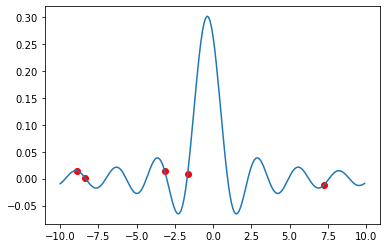

In [5]:
x_samples, y_samples, f = get_random_sinc_samples()

x = np.arange(-10, 10, .1)

plt.plot(x, f(x))
plt.scatter(x_samples, y_samples, c='r')
plt.show()

In [6]:
class SincDataset(Dataset):
    def __init__(self, len: int,
                 contexts: Optional[int] = 5,
                 queries: Optional[int] = 3,
                 lower: Optional[float] = -10,
                 upper: Optional[float] = 10,
                ):
        self.len = len
        self.lower = lower
        self.upper = upper
        self.contexts = contexts
        self.queries = queries
        
        self._sample()
        
    def _sample(self):
        self.samples = [get_random_sinc_samples(self.contexts + self.queries, self.lower, self.upper) for _ in range(self.len)]
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        xs, ys, f = self.samples[idx]

        context_x, context_y = xs[:self.contexts], ys[:self.contexts]
        queries_x, queries_y = xs, ys #xs[self.contexts:], ys[self.contexts:]
        
        return (context_x.unsqueeze(-1), context_y.unsqueeze(-1), queries_x.unsqueeze(-1)), queries_y.unsqueeze(-1)
        
        

In [7]:
ds_dummy = SincDataset(10_000, contexts=50, queries=10)

In [8]:
(context_x, context_y, queries_x), y = ds_dummy[random.randint(0, 10_000)]

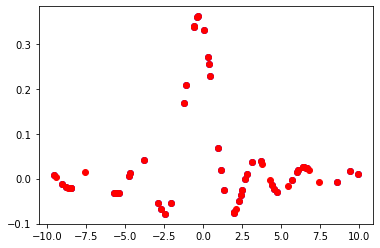

In [9]:
plt.scatter(context_x, context_y, c='b')
plt.scatter(queries_x, y, c='r')

In [10]:
ds_train = SincDataset(300_000, contexts=10, queries=20)
ds_valid = SincDataset(5_000, contexts=10, queries=20)

In [11]:
dl_train = DataLoader(ds_train, batch_size=640, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=640, shuffle=False)

In [12]:
(context_x, context_y, queries_x), y = next(iter(dl_train))

In [13]:
context_x.shape, context_y.shape, queries_x.shape, y.shape

(torch.Size([640, 10, 1]),
 torch.Size([640, 10, 1]),
 torch.Size([640, 30, 1]),
 torch.Size([640, 30, 1]))

## Model

```
context x, context y, target x, target y
torch.Size([16, 217, 2]) torch.Size([16, 217, 1]) torch.Size([16, 732, 2]) torch.Size([16, 732, 1])
```

In [14]:
class Linear(nn.Module):
    """
    Linear Module
    """
    def __init__(self, in_dim, out_dim, bias=True, w_init='linear'):
        """
        :param in_dim: dimension of input
        :param out_dim: dimension of output
        :param bias: boolean. if True, bias is included.
        :param w_init: str. weight inits with xavier initialization.
        """
        super(Linear, self).__init__()
        self.linear_layer = nn.Linear(in_dim, out_dim, bias=bias)

        nn.init.xavier_uniform_(
            self.linear_layer.weight,
            gain=nn.init.calculate_gain(w_init))

    def forward(self, x):
        return self.linear_layer(x)

class LatentEncoder(nn.Module):
    """
    Latent Encoder [For prior, posterior]
    """
    def __init__(self, num_hidden, num_latent, input_dim=2):
        super(LatentEncoder, self).__init__()
        self.input_projection = Linear(input_dim, num_hidden)
        self.self_attentions = nn.ModuleList([Attention(num_hidden) for _ in range(2)])
        self.penultimate_layer = Linear(num_hidden, num_hidden, w_init='relu')
        self.mu = Linear(num_hidden, num_latent)
        self.log_sigma = Linear(num_hidden, num_latent)

    def forward(self, x, y):
        # concat location (x) and value (y)
        encoder_input = torch.cat([x,y], dim=-1)
        
        # project vector with dimension 3 --> num_hidden
        encoder_input = self.input_projection(encoder_input)
        
        # self attention layer
        for attention in self.self_attentions:
            encoder_input, _ = attention(encoder_input, encoder_input, encoder_input)
        
        # mean
        hidden = encoder_input.mean(dim=1)
        hidden = torch.relu(self.penultimate_layer(hidden))
        
        # get mu and sigma
        mu = self.mu(hidden)
        log_sigma = self.log_sigma(hidden)
        
        # reparameterization trick
        std = torch.exp(0.5 * log_sigma)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)
        
        # return distribution
        return mu, log_sigma, z
    
class DeterministicEncoder(nn.Module):
    """
    Deterministic Encoder [r]
    """
    def __init__(self, num_hidden, num_latent, input_dim=2, new_attention=NEW_ATTENTION, n_attention_layers=4):
        super(DeterministicEncoder, self).__init__()
        
        if new_attention is False:
            self.self_attentions = nn.ModuleList([Attention(num_hidden) for _ in range(n_attention_layers)])
            self.cross_attentions = nn.ModuleList([Attention(num_hidden) for _ in range(n_attention_layers)])
        else:
            self.self_attentions = nn.ModuleList([NewAttention(num_hidden) for _ in range(n_attention_layers)])
            self.cross_attentions = nn.ModuleList([NewAttention(num_hidden) for _ in range(n_attention_layers)])

        self.input_projection = Linear(input_dim, num_hidden)
        self.context_projection = Linear(1, num_hidden)  # TK 2->1 line below as well
        self.target_projection = Linear(1, num_hidden)
        self.new_attention = new_attention

    def forward(self, context_x, context_y, target_x):
        # concat context location (x), context value (y)
        encoder_input = torch.cat([context_x,context_y], dim=-1)
        
        # project vector with dimension 3 --> num_hidden
        encoder_input = self.input_projection(encoder_input)
        
        if self.new_attention is False:
            # self attention layer
            for attention in self.self_attentions:
                encoder_input, _ = attention(encoder_input, encoder_input, encoder_input)

            # query: target_x, key: context_x, value: representation
            query = self.target_projection(target_x)
            keys = self.context_projection(context_x)

            # cross attention layer
            for attention in self.cross_attentions:
                query, _ = attention(keys, encoder_input, query)

            return query
        
        else:
            query = self.target_projection(target_x)
            keys = self.context_projection(context_x)
            for attention in self.cross_attentions:
                query, _ = attention(keys, query, encoder_input, query)

            return query

class Decoder(nn.Module):
    """
    Decoder for generation 
    """
    def __init__(self, num_hidden, deterministic = DETERMINISTIC):
        self.input_vectors = 2 if deterministic is True else 3
        
        super(Decoder, self).__init__()
        self.target_projection = Linear(1, num_hidden)  # TK 2->1
        self.linears = nn.ModuleList([Linear(num_hidden * self.input_vectors, num_hidden * self.input_vectors, w_init='relu') for _ in range(3)])
        self.final_projection = Linear(num_hidden * self.input_vectors, 1)
        
    def forward(self, r, z, target_x):
        batch_size, num_targets, _ = target_x.size()
        # project vector with dimension 2 --> num_hidden
        target_x = self.target_projection(target_x)
        
        # concat all vectors (r,z,target_x)
        if z is not None:
            hidden = torch.cat([torch.cat([r,z], dim=-1), target_x], dim=-1)
        else:
            hidden = torch.cat([r, target_x], dim=-1)
        
        # mlp layers
        for linear in self.linears:
            hidden = torch.relu(linear(hidden))
            
        # get mu and sigma
        y_pred = self.final_projection(hidden)
        
        return y_pred

In [15]:
class LatentModel(nn.Module):
    """
    Latent Model (Attentive Neural Process)
    """
    def __init__(self, num_hidden, deterministic=True):
        super(LatentModel, self).__init__()
        self.deterministic = deterministic
        if not self.deterministic:
            self.latent_encoder = LatentEncoder(num_hidden, num_hidden)
        self.deterministic_encoder = DeterministicEncoder(num_hidden, num_hidden)
        self.decoder = Decoder(num_hidden, deterministic)
        self.loss = nn.MSELoss()
        
    def forward(self, context_x, context_y, target_x, target_y=None):
        num_targets = target_x.size(1)
        
        if self.deterministic is False:
            prior_mu, prior_var, prior = self.latent_encoder(context_x, context_y)
        
            # For training
            if target_y is not None:
                posterior_mu, posterior_var, posterior = self.latent_encoder(target_x, target_y)
                z = posterior
        
            # For Generation
            else:
                z = prior
        
            z = z.unsqueeze(1).repeat(1,num_targets,1) # [B, T_target, H]
            
        else:
            z = None

            
        r = self.deterministic_encoder(context_x, context_y, target_x) # [B, T_target, H]
        
        # mu should be the prediction of target y
        y_pred = self.decoder(r, z, target_x)
        
        # For Training
        if target_y is not None:
            # get log probability
            loss = self.loss(y_pred, target_y)
            
            # get KL divergence between prior and posterior
            kl = self.kl_div(prior_mu, prior_var, posterior_mu, posterior_var) if not self.deterministic else None
            
            # maximize prob and minimize KL divergence
            loss = loss + kl if not self.deterministic else loss
        
        # For Generation
        else:
            log_p = None
            kl = None
            loss = None
            
        return y_pred, kl, loss
    
    def kl_div(self, prior_mu, prior_var, posterior_mu, posterior_var):
        kl_div = (torch.exp(posterior_var) + (posterior_mu-prior_mu) ** 2) / torch.exp(prior_var) - 1. + (prior_var - posterior_var)
        kl_div = 0.5 * kl_div.sum()
        return kl_div

## Original

In [16]:
class MultiheadAttention(nn.Module):
    """
    Multihead attention mechanism (dot attention)
    """
    def __init__(self, num_hidden_k):
        """
        :param num_hidden_k: dimension of hidden 
        """
        super(MultiheadAttention, self).__init__()
        print("MultiheadAttention")
        self.num_hidden_k = num_hidden_k
        self.attn_dropout = nn.Dropout(p=0.1)

    def forward(self, key, value, query):

        # Get attention score
        attn = torch.bmm(query, key.transpose(1, 2))
        attn = attn / math.sqrt(self.num_hidden_k)
        
        attn = torch.softmax(attn, dim=-1)

        # Dropout
        attn = self.attn_dropout(attn)
        
        # Get Context Vector
        result = torch.bmm(attn, value)

        return result, attn


class Attention(nn.Module):
    """
    Attention Network
    """
    def __init__(self, num_hidden, h=8):
        """
        :param num_hidden: dimension of hidden
        :param h: num of heads 
        """
        super(Attention, self).__init__()
        print("Attention")
        self.num_hidden = num_hidden
        self.num_hidden_per_attn = num_hidden // h
        self.h = h

        self.key = Linear(num_hidden, num_hidden, bias=False)
        self.value = Linear(num_hidden, num_hidden, bias=False)
        self.query = Linear(num_hidden, num_hidden, bias=False)

        self.multihead = MultiheadAttention(self.num_hidden_per_attn)

        self.residual_dropout = nn.Dropout(p=0.1)

        self.final_linear = Linear(num_hidden * 2, num_hidden)

        self.layer_norm = nn.LayerNorm(num_hidden)

    def forward(self, key, value, query):

        batch_size = key.size(0)
        seq_k = key.size(1)
        seq_q = query.size(1)
        residual = query
        
        # Make multihead
        key = self.key(key).view(batch_size, seq_k, self.h, self.num_hidden_per_attn)
        value = self.value(value).view(batch_size, seq_k, self.h, self.num_hidden_per_attn)
        query = self.query(query).view(batch_size, seq_q, self.h, self.num_hidden_per_attn)

        key = key.permute(2, 0, 1, 3).contiguous().view(-1, seq_k, self.num_hidden_per_attn)
        value = value.permute(2, 0, 1, 3).contiguous().view(-1, seq_k, self.num_hidden_per_attn)
        query = query.permute(2, 0, 1, 3).contiguous().view(-1, seq_q, self.num_hidden_per_attn)

        # Get context vector
        result, attns = self.multihead(key, value, query)

        # Concatenate all multihead context vector
        result = result.view(self.h, batch_size, seq_q, self.num_hidden_per_attn)
        result = result.permute(1, 2, 0, 3).contiguous().view(batch_size, seq_q, -1)
        
        # Concatenate context vector with input (most important)
        result = torch.cat([residual, result], dim=-1)
        
        # Final linear
        result = self.final_linear(result)

        # Residual dropout & connection
        result = self.residual_dropout(result)
        result = result + residual

        # Layer normalization
        result = self.layer_norm(result)

        return result, attns

## New

```
NP(8)(torch.ones([8,3,2]), torch.ones([8,5,1])).size()

key torch.Size([8, 3, 1]) value torch.Size([8, 3, 8]) query torch.Size([8, 5, 1])
result torch.Size([8, 5, 8]) attn torch.Size([8, 40, 24])
```

In [17]:
def init_kernels(n_heads, n_kernel, slope=10., noise=.01):
    step = 1./n_kernel
    kernels = torch.exp(-slope*torch.arange(0, 1, step=step)).unsqueeze(0).repeat(n_heads, 1) + torch.randn(1, n_kernel) * noise
    return kernels.div(kernels.sum()).unsqueeze(1).unsqueeze(1)

In [18]:
# implement setcnn https://github.com/YannDubs/Neural-Process-Family/blob/master/npf/architectures/setcnn.py
'''
def weights_init(module, **kwargs):
    """Initialize a module and all its descendents.
    Parameters
    ----------
    module : nn.Module
       module to initialize.
    """
    
    module.is_resetted = True
    for m in module.modules():
        try:
            if hasattr(module, "reset_parameters") and module.is_resetted:
                # don't reset if resetted already (might want special)
                continue
        except AttributeError:
            pass
 
        if isinstance(m, torch.nn.modules.conv._ConvNd):
            # used in https://github.com/brain-research/realistic-ssl-evaluation/
            torch.nn.init.kaiming_normal_(m.weight, mode="fan_out", **kwargs)
        elif isinstance(m, nn.Linear):
            linear_init(m, **kwargs)
        elif isinstance(m, torch.nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
'''
def get_activation_name(activation):
    """Given a string or a `torch.nn.modules.activation` return the name of the activation."""
    if isinstance(activation, str):
        return activation
 
    mapper = {
        torch.nn.LeakyReLU: "leaky_relu",
        torch.nn.ReLU: "relu",
        torch.nn.Tanh: "tanh",
        torch.nn.Sigmoid: "sigmoid",
        torch.nn.Softmax: "sigmoid",
    }
    for k, v in mapper.items():
        if isinstance(activation, k):
            return k
 
    raise ValueError("Unkown given activation type : {}".format(activation))
 
def linear_init(module, activation="leaky_relu"):
    """Initialize a linear layer.
    Parameters
    ----------
    module : nn.Module
       module to initialize.
    activation : `torch.nn.modules.activation` or str, optional
        Activation that will be used on the `module`.
    """
    x = module.weight
 
    if module.bias is not None:
        module.bias.data.zero_()
 
    if activation is None:
        return torch.nn.init.xavier_uniform_(x)
 
    activation_name = get_activation_name(activation)
 
    if activation_name == "leaky_relu":
        a = 0 if isinstance(activation, str) else activation.negative_slope
        return torch.nn.init.kaiming_uniform_(x, a=a, nonlinearity="leaky_relu")
    elif activation_name == "relu":
        return torch.nn.init.kaiming_uniform_(x, nonlinearity="relu")
    elif activation_name in ["sigmoid", "tanh"]:
        return torch.nn.init.xavier_uniform_(x, gain=get_gain(activation))
 

def get_gain(activation):
    """Given an object of `torch.nn.modules.activation` or an activation name
    return the correct gain."""
    if activation is None:
        return 1
 
    activation_name = get_activation_name(activation)
 
    param = None if activation_name != "leaky_relu" else activation.negative_slope
    gain = torch.nn.init.calculate_gain(activation_name, param)
 
    return gain


class MLP(torch.nn.Module):
    """General MLP class.
    Parameters
    ----------
    input_size: int
    output_size: int
    hidden_size: int, optional
        Number of hidden neurones.
    n_hidden_layers: int, optional
        Number of hidden layers.
    activation: callable, optional
        Activation function. E.g. `nn.RelU()`.
    is_bias: bool, optional
        Whether to use biaises in the hidden layers.
    dropout: float, optional
        Dropout rate.
    is_force_hid_smaller : bool, optional
        Whether to force the hidden dimensions to be smaller or equal than in and out.
        If not, it forces the hidden dimension to be larger or equal than in or out.
    is_res : bool, optional
        Whether to use residual connections.
    """
 
    def __init__(
        self,
        input_size,
        output_size,
        hidden_size=32,
        n_hidden_layers=1,
        activation=torch.nn.LeakyReLU(),
        is_bias=True,
        dropout=0,
        is_force_hid_smaller=False,
        is_res=False,
    ):
        super().__init__()
 
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_hidden_layers = n_hidden_layers
        self.is_res = is_res
 
        if is_force_hid_smaller and self.hidden_size > max(
            self.output_size, self.input_size
        ):
            self.hidden_size = max(self.output_size, self.input_size)
            txt = "hidden_size={} larger than output={} and input={}. Setting it to {}."
            warnings.warn(
                txt.format(hidden_size, output_size, input_size, self.hidden_size)
            )
        elif self.hidden_size < min(self.output_size, self.input_size):
            self.hidden_size = min(self.output_size, self.input_size)
            txt = (
                "hidden_size={} smaller than output={} and input={}. Setting it to {}."
            )
            warnings.warn(
                txt.format(hidden_size, output_size, input_size, self.hidden_size)
            )
 
        self.dropout = torch.nn.Dropout(p=dropout) if dropout > 0 else torch.nn.Identity()
        self.activation = activation
 
        self.to_hidden = torch.nn.Linear(self.input_size, self.hidden_size, bias=is_bias)
        self.linears = torch.nn.ModuleList(
            [
                torch.nn.Linear(self.hidden_size, self.hidden_size, bias=is_bias)
                for _ in range(self.n_hidden_layers - 1)
            ]
        )
        self.out = torch.nn.Linear(self.hidden_size, self.output_size, bias=is_bias)
 
        self.reset_parameters()
 
    def forward(self, x):
        out = self.to_hidden(x)
        out = self.activation(out)
        x = self.dropout(out)
 
        for linear in self.linears:
            out = linear(x)
            out = self.activation(out)
            if self.is_res:
                out = out + x
            out = self.dropout(out)
            x = out
 
        out = self.out(x)
        return out
 
    def reset_parameters(self):
        linear_init(self.to_hidden, activation=self.activation)
        for lin in self.linears:
            linear_init(lin, activation=self.activation)
        linear_init(self.out)

class NewMultiheadAttention(torch.nn.Module):
    """
    Multihead attention mechanism (MLP kernel attention)
    """
    def __init__(self, num_hidden, h, nn_dim):
        super(NewMultiheadAttention, self).__init__()

        print("NewMultiheadAttention")
        self.N = 32
        self.nn_dim = nn_dim
        self.num_hidden = num_hidden
        self.h = h
        self.num_hidden_per_attn = num_hidden // h
        self.attn_dropout = torch.nn.Dropout(p=0.1)
        #self.hl = MLP(self.nn_dim, self.num_hidden*self.h, hidden_size=32, n_hidden_layers=2, dropout=0) #h, h<-hidden 
        self.bias = torch.nn.Parameter(torch.zeros(self.h))        
        self.real_amps = torch.nn.Parameter(torch.tensor(init_kernels(self.h, self.N), requires_grad=True))
        #self.real_amps = torch.nn.Parameter(torch.ones(self.h, 1, 1, self.N, requires_grad=True))
        self.imag_amps = torch.nn.Parameter(torch.zeros(self.h, 1, 1, self.N, requires_grad=True))

        
        self.freqs = torch.nn.Parameter(self.get_freqs(self.N), requires_grad=False)
    #def reset_parameters(self):
    #    weights_init(self)
 
    def forward(self, key, value, query):
        import pdb

        batch_size = key.size(0)
        seq_k = key.size(1)
        seq_q = query.size(1)
 
        # Make multihead
        '''
        key = key.view(batch_size, seq_k, self.h, self.num_hidden_per_attn)
        value = value.view(batch_size, seq_k, self.h, self.num_hidden_per_attn)
        query = query.view(batch_size, seq_q, self.h, self.num_hidden_per_attn)
 
        key = key.permute(2, 0, 1, 3).contiguous().view(-1, seq_k, self.num_hidden_per_attn)
        value = value.permute(2, 0, 1, 3).contiguous().view(-1, seq_k, self.num_hidden_per_attn)
        query = query.permute(2, 0, 1, 3).contiguous().view(-1, seq_q, self.num_hidden_per_attn)
        '''
 
        # Get dot attention score
        #attn = torch.bmm(query, key.transpose(1, 2))
 
        # norm for cosine similarity
        '''
        norm_query = query.norm(p=2, dim=-1, keepdim=True)
        norm_key = key.norm(p=2, dim=-1, keepdim=True)
        attn = torch.bmm(query.div(norm_query.expand_as(query)), key.div(norm_key.expand_as(key)).transpose(1, 2))
        '''
        
        # mlp for translation invariant kernel (experimental)
        #batch_size * h , num_hidden // h, seq
 
        '''
        seq_length = attn.size()[-1]   
        num_hidden_per_head = attn.size()[-2]
        attn = attn.view(self.h, -1, num_hidden_per_head, seq_length).permute(1, 2, 3, 0).contiguous()
        attn = self.hl(attn)
        attn = attn.permute(3, 0, 1, 2).contiguous().view(-1, num_hidden_per_head, seq_length)
        '''        
 
        '''
        attn = attn / math.sqrt(self.num_hidden_per_attn)
        attn = torch.softmax(attn, dim=-1)
 
        # Dropout
        attn = self.attn_dropout(attn)
        
        # Get Context Vector
        result = torch.bmm(attn, value)
        
        # Concatenate all multihead context vector
        result = result.view(self.h, batch_size, seq_q, self.num_hidden_per_attn)
        result = result.permute(1, 2, 0, 3).contiguous().view(batch_size, seq_q, -1)
        '''
        """
        # additive to mimic convolution with learable kernel (very experimental)
        # 1. repeat for keys, queries
        #pdb.set_trace()
        key = key.view(batch_size, seq_k, 1, key.size(-1)).repeat([1, 1, seq_q, 1])  # TK n_dim -> key.size ...
        query = query.view(batch_size, 1, seq_q, query.size(-1)).repeat([1, seq_k, 1, 1])  # TK
 
        # 2. add matrices
        #pdb.set_trace()
        attn = key - query
 
        # 3. MLP-> b x k x q x h x num_hidden
        attn = self.hl(attn)
        attn = attn.view(-1, seq_k, seq_q, self.h, self.num_hidden)
        #attn = attn.permute(0, 2, 3, 4, 1).contiguous().view(-1, seq_q, self.h, self.num_hidden*seq_k)
        #attn = attn / (self.num_hidden*seq_k)
        #attn = torch.softmax(attn, dim=-1)
        #attn = torch.tanh(attn)
        #attn = attn.view(-1, seq_q, self.h, self.num_hidden, seq_k).permute(0, 2, 1, 3, 4).contiguous()
        
        # Do convolution
        attn = attn.permute(0, 2, 3, 1, 4).contiguous().view(-1, seq_q*self.h, seq_k*self.num_hidden)
        attn = attn / torch.sum(torch.abs(attn), dim=-1, keepdim=True)
        value = value.view(-1, 1, seq_k*self.num_hidden) #TODO reshape
        result = torch.bmm(attn, value.transpose(1, 2))
        result = result.view(-1, seq_q, self.h)

        # apply bias
        result = result + self.bias
        
        batch_size = key.size(0)
        return result, attn
        """
        
        
        
        key = key.view(batch_size, seq_k, self.h, 1)
        value = value.view(batch_size, seq_k, self.h, self.num_hidden_per_attn)
        query = query.view(batch_size, seq_q, self.h, 1)
 
        key = key.permute(2, 0, 1, 3).contiguous().view(-1, seq_k, 1)
        value = value.permute(2, 0, 1, 3).contiguous().view(-1, seq_k, self.num_hidden_per_attn)
        query = query.permute(2, 0, 1, 3).contiguous().view(-1, seq_q, 1)
        
        # do sin and cos
        freqs = self.freqs.unsqueeze(0).unsqueeze(0).repeat(self.h * batch_size, 1, 1)
        pdb.set_trace()
        
        query_prime = freqs * query       # 5120, 30, 32
        key_prime = freqs * key           # 5120, 10, 32
        
        imag_amps = self.imag_amps.repeat(1, batch_size, 1, 1).view(-1, 1, self.N)  # 5120, 1, 32
        real_amps = self.real_amps.repeat(1, batch_size, 1, 1).view(-1, 1, self.N)  # 5120, 1, 32
        
        sin_query_prime = torch.sin(query_prime)
        cos_query_prime = torch.cos(query_prime)
        sin_key_prime   = torch.sin(key_prime)
        cos_key_prime   = torch.cos(key_prime)
        """
        ipdb> sin_query_prime.shape
        torch.Size([5120, 30, 32])
        ipdb> cos_query_prime.shape
        torch.Size([5120, 30, 32])
        ipdb> sin_key_prime.shape
        torch.Size([5120, 10, 32])
        ipdb> cos_key_prime.shape
        torch.Size([5120, 10, 32])
        """
        trig_query = torch.cat([
            real_amps * cos_query_prime,
            real_amps * sin_query_prime,
            imag_amps * sin_query_prime,
            -imag_amps* cos_query_prime,
        ], -1)
        
        trig_key = torch.cat([
            cos_key_prime,
            sin_key_prime,
            cos_key_prime,
            sin_key_prime,
        ], -1)
        
        """
        ipdb> trig_key.shape
        torch.Size([5120, 10, 128])
        ipdb> trig_query.shape
        torch.Size([5120, 30, 128])
        """
        # value 5120, 10, 8
        
        k_times_v = torch.bmm(trig_key.transpose(1,2), value)
        
        q_times_k_times_v = torch.bmm(trig_query, k_times_v)
        
        """
        ipdb> k_times_v.shape
        torch.Size([5120, 128, 8])
        ipdb> print(q_times_k_times_v.shape)
        torch.Size([5120, 30, 8])
        """
        
        result = q_times_k_times_v.view(self.h, batch_size, seq_q, self.num_hidden_per_attn).permute(1, 2, 0, 3).contiguous().view(batch_size, seq_q, -1)
        # result 640, 30, 64
        return result, None
    
    def get_freqs(self, N_kernel):
        step = 1 / (N_kernel -1 )
        
        
        #return torch.arange(0, 1 + step, step=step) * 2 * pi
    
        return torch.arange(0, 1 + step, step=step) * N_kernel * pi

class NewAttention(torch.nn.Module):
    """
    Attention Network
    """
    def __init__(self, num_hidden, h=8):
        """
        :param num_hidden: dimension of hidden
        :param h: num of heads 
        """
        super(NewAttention, self).__init__()
        self.alpha = nn.Parameter(torch.ones(1, requires_grad=True))
        print("NewAttention")
        self.num_hidden = num_hidden
        self.num_hidden_per_attn = num_hidden // h
        self.h = h

        nn_dim = num_hidden
        num_bn = self.num_hidden #num_hidden // 4
        self.key = torch.nn.Linear(num_hidden, h, bias=False)
        self.value = torch.nn.Linear(num_hidden, num_bn, bias=False)
        self.query = torch.nn.Linear(num_hidden, h, bias=False)
 
        self.multihead = NewMultiheadAttention(num_bn, self.h, nn_dim=nn_dim)
 
        self.residual_dropout = torch.nn.Dropout(p=0.1)
 
        #self.final_linear = torch.nn.Linear(num_hidden*2, num_hidden)
        self.final_linear = torch.nn.Linear(num_hidden, num_hidden)
 
        self.layer_norm1 = torch.nn.LayerNorm(num_hidden)
 
        self.mlp = MLP(num_hidden, num_hidden)
        self.layer_norm2 = torch.nn.LayerNorm(num_hidden) #num_hidden
  
    #def reset_parameters(self):
    #    weights_init(self)
 
    def forward(self, key, query, value, residual):
        batch_size = key.size(0)
        seq_k = key.size(1)
        seq_q = query.size(1)
        import pdb
        #pdb.set_trace()
        key = self.key(key)
        value = self.value(value)
        query = self.query(query)

        # value for bottleneck            
        #value = self.layer_norm2(value)
        #value = torch.nn.LeakyReLU()(value)

        # Get context vector
        result, attns = self.multihead(key, value, query)

        # Concatenate context vector with input (most important)
        #result = torch.cat([residual, result], dim=-1)

        result = self.final_linear(result)

        # Residual dropout & connection            
        #result = self.residual_dropout(result)            
        #result = self.layer_norm1(result)
        result = torch.nn.LeakyReLU()(result) #LeakyReLU

        scale = torch.sigmoid(self.mlp(torch.mean(result, 1, keepdim=True))) # extra from bottom
        result = residual + result * scale

        # Residual dropout & fully connected
        '''
        residual = result
        result = self.mlp(result)
        result = self.residual_dropout(result)
        result = result + residual
        result = self.layer_norm2(result)
        '''

        return result, attns        

In [24]:
model = LatentModel(64)
model = model.train()

NewAttention
NewMultiheadAttention
NewAttention
NewMultiheadAttention
NewAttention
NewMultiheadAttention
NewAttention
NewMultiheadAttention
NewAttention
NewMultiheadAttention
NewAttention
NewMultiheadAttention
NewAttention
NewMultiheadAttention
NewAttention
NewMultiheadAttention


<ipython-input-18-2890412a14d3>:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.real_amps = torch.nn.Parameter(torch.tensor(init_kernels(self.h, self.N), requires_grad=True))
<ipython-input-18-2890412a14d3>:145: UserWarning: hidden_size=32 smaller than output=64 and input=64. Setting it to 64.
  warnings.warn(


In [25]:
context_x.shape, context_y.shape, queries_x.shape

(torch.Size([640, 10, 1]), torch.Size([640, 10, 1]), torch.Size([640, 30, 1]))

In [ ]:
y_pred, kl, loss = model(context_x, context_y, queries_x, y)

> <ipython-input-18-2890412a14d3>(311)forward()
    309         pdb.set_trace()
    310 
--> 311         query_prime = freqs * query
    312         key_prime = freqs * key
    313 

ipdb> n
> <ipython-input-18-2890412a14d3>(312)forward()
    310 
    311         query_prime = freqs * query
--> 312         key_prime = freqs * key
    313 
    314         imag_amps = self.imag_amps.repeat(1, batch_size, 1, 1).view(-1, 1, self.N)

ipdb> key_prime.shape
*** NameError: name 'key_prime' is not defined
ipdb> n
> <ipython-input-18-2890412a14d3>(314)forward()
    312         key_prime = freqs * key
    313 
--> 314         imag_amps = self.imag_amps.repeat(1, batch_size, 1, 1).view(-1, 1, self.N)
    315         real_amps = self.real_amps.repeat(1, batch_size, 1, 1).view(-1, 1, self.N)
    316 

ipdb> key_prime.shape
torch.Size([5120, 10, 32])
ipdb> print(query_prime.shape)
torch.Size([5120, 30, 32])
ipdb> n
> <ipython-input-18-2890412a14d3>(315)forward()
    313 
    314         imag_amps = s

ipdb> cos_query_prime.shape
torch.Size([5120, 30, 32])
ipdb> sin_key_prime.shape
torch.Size([5120, 10, 32])
ipdb> cos_key_prime.shape
torch.Size([5120, 10, 32])
ipdb> n
> <ipython-input-18-2890412a14d3>(323)forward()
    321 
    322         trig_query = torch.cat([
--> 323             real_amps * cos_query_prime,
    324             real_amps * sin_query_prime,
    325             imag_amps * sin_query_prime,

ipdb> n
> <ipython-input-18-2890412a14d3>(324)forward()
    322         trig_query = torch.cat([
    323             real_amps * cos_query_prime,
--> 324             real_amps * sin_query_prime,
    325             imag_amps * sin_query_prime,
    326             -imag_amps* cos_query_prime,

ipdb> n
> <ipython-input-18-2890412a14d3>(325)forward()
    323             real_amps * cos_query_prime,
    324             real_amps * sin_query_prime,
--> 325             imag_amps * sin_query_prime,
    326             -imag_amps* cos_query_prime,
    327         ], -1)

ipdb> n
> <ipyt

ipdb> trig_key.shape
torch.Size([5120, 10, 128])
ipdb> trig_query.shape
torch.Size([5120, 30, 128])
ipdb> n
> <ipython-input-18-2890412a14d3>(344)forward()
    342         k_times_v = torch.bmm(trig_key.transpose(1,2), value)
    343 
--> 344         q_times_k_times_v = torch.bmm(trig_query, k_times_v)
    345 
    346         result = q_times_k_times_v.view(self.h, batch_size, seq_q, self.num_hidden_per_attn).permute(1, 2, 0, 3).contiguous().view(batch_size, seq_q, -1)

ipdb> n
> <ipython-input-18-2890412a14d3>(346)forward()
    344         q_times_k_times_v = torch.bmm(trig_query, k_times_v)
    345 
--> 346         result = q_times_k_times_v.view(self.h, batch_size, seq_q, self.num_hidden_per_attn).permute(1, 2, 0, 3).contiguous().view(batch_size, seq_q, -1)
    347 
    348         return result, None

ipdb> k_times_v.shape
torch.Size([5120, 128, 8])
ipdb> print(q_times_k_times_v.shape)
torch.Size([5120, 30, 8])
ipdb> value.shape
torch.Size([5120, 10, 8])
ipdb> n
> <ipython-input-1

In [22]:
#y_pred.shape

In [23]:
class Model(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = LatentModel(128)
        #self.accuracy = pl.metrics.Accuracy()
    
    def forward(self, context_x, context_y, queries_x, y=None):

        # in lightning, forward defines the prediction/inference actions
        return self.model(context_x, context_y, queries_x, y)

    def training_step(self, batch, batch_idx):

        (context_x, context_y, queries_x), y = batch
        y_pred, kl, loss = self.forward(context_x, context_y, queries_x, y)
        
        #self.accuracy(preds[:,0,0], y)
        self.log('train_loss', loss)

        return loss
    
    def validation_step(self, batch, batch_idx):
        (context_x, context_y, queries_x), y = batch
        y_pred, kl, loss = self.forward(context_x, context_y, queries_x, y)

        self.log('valid_loss', loss)

        return loss
    
    def training_epoch_end(self, outs):
        # log epoch metric
        pass #self.log('train_acc_epoch', self.accuracy.compute())
        
    def validation_epoch_end(self, outs):
        # log epoch metric
        pass #self.log('valid_acc_epoch', self.accuracy.compute())


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)  # TK

        return optimizer

In [24]:
mlf_logger = MLFlowLogger(
    experiment_name="Default",
    tracking_uri="http://localhost:5000"
)

In [25]:
pl_model = Model()

NewAttention
NewMultiheadAttention
NewAttention
NewMultiheadAttention
NewAttention
NewMultiheadAttention
NewAttention
NewMultiheadAttention
NewAttention
NewMultiheadAttention
NewAttention
NewMultiheadAttention
NewAttention
NewMultiheadAttention
NewAttention
NewMultiheadAttention


<ipython-input-18-631b549584ba>:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.real_amps = torch.nn.Parameter(torch.tensor(init_kernels(self.h, self.N), requires_grad=True))
<ipython-input-18-631b549584ba>:145: UserWarning: hidden_size=32 smaller than output=128 and input=128. Setting it to 128.
  warnings.warn(


In [26]:
trainer = pl.Trainer(max_epochs=10, gpus=1, logger=mlf_logger)
trainer.fit(pl_model, dl_train, dl_valid)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | LatentModel | 751 K 
--------------------------------------
750 K     Trainable params
256       Non-trainable params
751 K     Total params
/home/fabiograetz/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

/home/fabiograetz/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

1

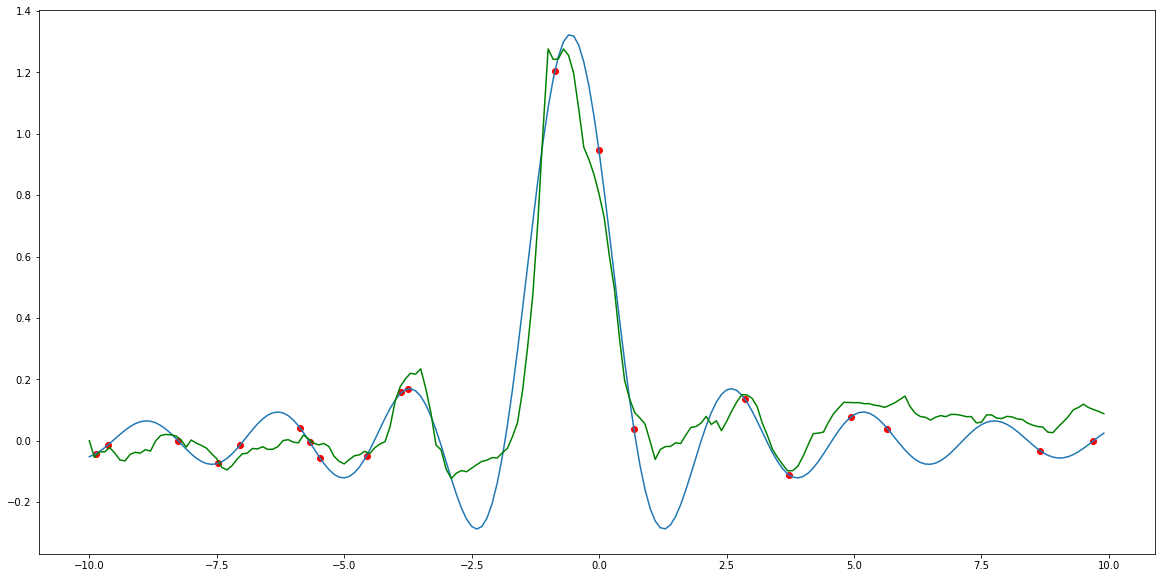

In [32]:
pl_model.model = pl_model.model.eval().cuda()

num_contexts = 20
x_samples, y_samples, f = get_random_sinc_samples(num_samples=num_contexts)

context_x, context_y = x_samples.unsqueeze(-1).unsqueeze(0).cuda(), y_samples.unsqueeze(-1).unsqueeze(0).cuda()
queries_x = torch.arange(-10, 10, .1).unsqueeze(-1).unsqueeze(0).cuda()

with torch.no_grad():
    y_pred, kl, loss = pl_model(context_x, context_y, queries_x, None)

x = np.arange(-10, 10, .1)

plt.figure(figsize = (20, 10))
plt.plot(x, f(x))
plt.scatter(context_x.cpu(), context_y.cpu(), c='r')
plt.plot(queries_x[0,:,0].cpu(), y_pred[0,:,0].cpu(), c='g')
plt.show()

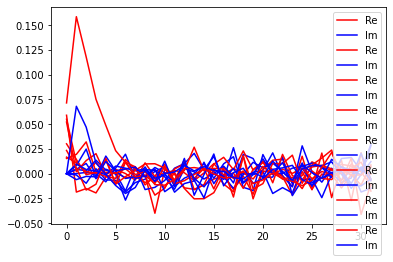

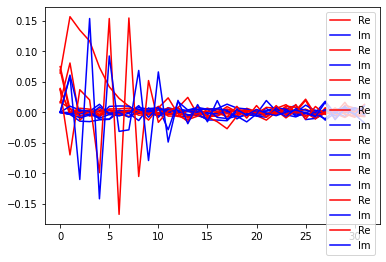

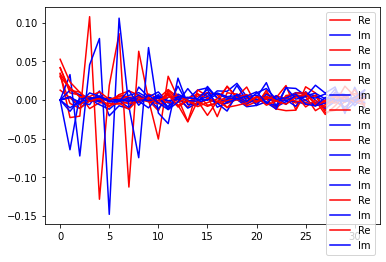

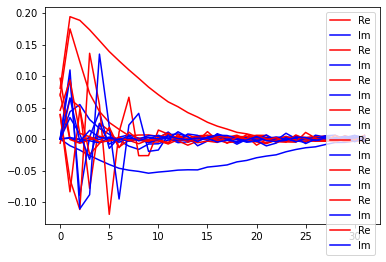

In [35]:
#viz kernel fourier features
for ca in list(pl_model.model.deterministic_encoder.cross_attentions): #z_attentions self_attentions
  mh = ca.multihead
  kr = mh.real_amps.view([mh.h, -1])
  ki = mh.imag_amps.view([mh.h, -1])
  plt.figure()
  for i in range(kr.size()[0]):
    plt.plot(kr[i].detach().cpu().numpy(), c='r', label='Re')
    plt.plot(ki[i].detach().cpu().numpy(), c='b', label='Im')
    plt.legend()

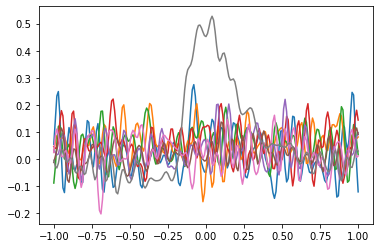

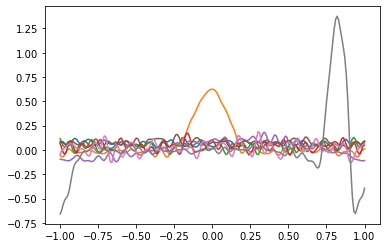

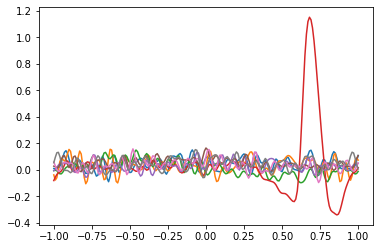

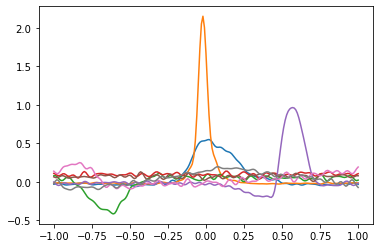

In [36]:
#viz kernel fourier features
for ca in list(pl_model.model.deterministic_encoder.cross_attentions): #z_attentions self_attentions
  mh = ca.multihead
  kr = mh.real_amps.view([mh.h, -1]).cpu()
  ki = mh.imag_amps.view([mh.h, -1]).cpu()
  pi = torch.acos(torch.zeros(1)).item() * 2
  freq = mh.get_freqs(ki.shape[-1]).cpu()

  plt.figure()
  for i in range(kr.size()[0]):
    step = 0.01
    x = torch.arange(-1, 1+step, step=step)
    y = [torch.sum(torch.cos(freq*x[q])*kr[i] + torch.sin(freq*x[q])*ki[i]).detach().cpu().numpy() for q in range(x.shape[0])]
    plt.plot(x.detach().numpy(), y)